# Neo4J Trellis v1.2: Sample based Analysis

    -  Check the success case only based on outputs
    -  Load the account info from Google Cloud Storage
    -  Remove Duplicate jobs and Duplicate jobs and nodes status
    -  Add 'dup' column with the number of dupilcated jobs
    
================

## Set up the environment


### Install py2neo for querying Neo4J 

In [74]:
!pip3 install py2neo

# *** add python path of py2neo in system

!pip3 install neotime
!pip3 install neobolt
!pip3 install pandas-gbq

!pip3 install papermill

!pip3 install google-cloud-storage
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install fsspec
!pip3 install gcsfs

     |████████████████████████████████| 645kB 2.4MB/s eta 0:00:01
     |████████████████████████████████| 133kB 8.3MB/s eta 0:00:01
     |████████████████████████████████| 51kB 5.6MB/s eta 0:00:011


### Import Packages

In [8]:
import py2neo as neo
from py2neo import Graph

from google.cloud import storage
import yaml

import pandas as pd
import pandas_gbq

import time
import numpy as np
import subprocess
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery

pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Load Neo4J DB

In [9]:
bucket_info='gbsc-gcp-project-mvp-dev-trellis'
credential_info='trellis-config.yaml'

In [13]:
## Option 1 : Read DB and Account Information in Google Storage (YAML)

# create storage client
storage_client = storage.Client()
# get bucket with name
bucket = storage_client.get_bucket(bucket_info)
# get bucket data as blob
blob = bucket.get_blob(credential_info)
# convert to string
yaml_data = blob.download_as_string()

account = yaml.load(yaml_data, Loader=yaml.FullLoader)

account['NEO4J_PASSPHRASE'] = "tcfWvWpF9CkDxwtLv99Jjc6VVS3NvPyLrpFaERqfA6W3l9DrJvulhW88MUi6ueWAz0Y8MU0fpXxKZlmQgswN4A"
account['NEO4J_HOST'] = "104.198.111.33"

## Main Account
graph = Graph(account['NEO4J_SCHEME']+'://'+account['NEO4J_HOST']+":"+str(account['NEO4J_PORT']), auth=(account['NEO4J_USER'],account['NEO4J_PASSPHRASE']))

/usr/local/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/usr/local/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://clou

## Generate Sample Status Table

### The number of nodes (Fastq, Ubam, Vcf, Cram, Crai) 

In [22]:
# Count Fastqs per sample

query = '''
    MATCH (s:Sample)
    WHERE NOT s.trellis_snvQa=true OR NOT EXISTS(s.trellis_snvQa)
    WITH s
    LIMIT 10000
    MATCH (s)<-[:GENERATED]-(:Person)-[:HAS_BIOLOGICAL_OME|HAS_SEQUENCING_READS*2]->(f:Fastq)
    RETURN s.sample AS sample, 
           COUNT(f) AS fastq
'''
start = time.time()
num_fastq = graph.run(query).to_data_frame()
end = time.time()
print(end - start)

num_fastq.set_index('sample')

3.6391208171844482


,fastq
sample,
SHIP4946367,8
SHIP4946378,8
SHIP4962319,8
SHIP4962320,8
SHIP4946370,8
...,...
SHIP5459367,8
SHIP5441710,8
SHIP5452799,8


In [23]:
# Count number of Fastq read groups
query = '''
    MATCH (s:Sample)
    WHERE NOT s.trellis_snvQa=true OR NOT EXISTS(s.trellis_snvQa)
    WITH s
    LIMIT 10000
    MATCH (s)<-[:GENERATED]-(:Person)-[:HAS_BIOLOGICAL_OME|HAS_SEQUENCING_READS*2]->(f:Fastq)
    RETURN s.sample AS sample,
           f.readGroup AS rg,
           COUNT(f.readGroup) AS rg_cnt
'''
start = time.time()
num_fastq_rg = graph.run(query).to_data_frame()
end = time.time()
print(end - start)

num_fastq_rgm=num_fastq_rg.loc[num_fastq_rg['rg_cnt']==2,['sample','rg']]

num_fastq_rgu=num_fastq_rgm['sample'].value_counts().rename_axis('sample').to_frame('fastq_rg')
num_fastq_rgu.reset_index(inplace=True)
num_fastq_rgu.set_index('sample')

19.94464898109436


,fastq_rg
sample,
SHIP5242626,8
SHIP5326106,6
SHIP5372133,6
SHIP5360369,6
SHIP5372687,6
...,...
SHIP5142497,1
SHIP5142487,1
SHIP5142504,1


In [24]:
# Count number of Ubam(s) per sample
query = '''
    MATCH (s:Sample)
    WHERE NOT s.trellis_snvQa=true OR NOT EXISTS(s.trellis_snvQa)
    WITH s
    LIMIT 10000
    MATCH (s)-[:GENERATED|WAS_USED_BY*4]->(u:Ubam)
    RETURN s.sample AS sample,
           COUNT(u) AS ubam,
           COUNT(DISTINCT u.readGroup) AS ubam_rg
'''
#query = "Match (s:Sample), (u:Ubam) WHERE s.sample = u.sample RETURN s.sample AS sample, count(u) AS ubam, count(distinct u.readGroup) as ubam_rg"
#query = "Match (s:Sample)-[*]->(u:Ubam) RETURN DISTINCT s.sample AS sample, count(distinct u) AS ubam, count(distinct u.readGroup) as ubam_rg"
start = time.time()
num_ubam = graph.run(query).to_data_frame()
end = time.time()
print(end - start)

num_ubam.set_index('sample')

5.4405529499053955


,ubam,ubam_rg
sample,,
SHIP4946367,9,4
SHIP4946378,8,4
SHIP4962319,8,4
SHIP4962320,8,4
SHIP4946370,8,4
...,...,...
SHIP5459367,8,4
SHIP5441710,8,4
SHIP5452799,8,4


In [26]:
# Count number of Vcfs per sample
query = '''
    MATCH (s:Sample)
    WHERE NOT s.trellis_snvQa=true OR NOT EXISTS(s.trellis_snvQa)
    WITH s
    LIMIT 10000
    MATCH (s)<-[:GENERATED]-(:Person)-[:HAS_BIOLOGICAL_OME]->(:Genome)-[:HAS_VARIANT_CALLS]->(v:Merged:Vcf)
    RETURN s.sample AS sample, COUNT(v) AS vcf
'''
#query = "Match (s:Sample), (v:Merged:Vcf) WHERE s.sample = v.sample RETURN s.sample AS sample, count(v) AS vcf"
#query = "Match (s:Sample)-[*]->(v:Merged:Vcf) RETURN DISTINCT s.sample AS sample, count(distinct v) AS vcf"
start = time.time()
num_vcf = graph.run(query).to_data_frame()
end = time.time()
print(end - start)

num_vcf.set_index('sample')

3.1025378704071045


,vcf
sample,
SHIP4946367,1
SHIP4946378,1
SHIP4962319,1
SHIP4962320,1
SHIP4946370,1
...,...
SHIP5459367,1
SHIP5441710,1
SHIP5452799,1


In [27]:
# Count number of Crams per sample
query = '''
    MATCH (s:Sample)
    WHERE NOT s.trellis_snvQa=true OR NOT EXISTS(s.trellis_snvQa)
    WITH s
    LIMIT 10000
    MATCH (s)<-[:GENERATED]-(:Person)-[:HAS_BIOLOGICAL_OME]->(:Genome)-[:HAS_SEQUENCING_READS]->(cm:Cram)
    RETURN s.sample AS sample, 
           COUNT(cm) AS cram
'''
#query = "Match (s:Sample), (cm:Cram) WHERE s.sample = cm.sample RETURN s.sample AS sample, count(cm) AS cram"
#query = "Match (s:Sample)-[*]->(cm:Cram) RETURN DISTINCT s.sample AS sample, count(distinct cm) AS cram"
start = time.time()
num_cram = graph.run(query).to_data_frame()
end = time.time()
print(end - start)

num_cram.set_index('sample')

3.3528082370758057


,cram
sample,
SHIP4946367,1
SHIP4946378,1
SHIP4962319,1
SHIP4962320,1
SHIP4946370,1
...,...
SHIP5459367,1
SHIP5441710,1
SHIP5452799,1


In [32]:
# Count number of Crais per sample
query = '''
    MATCH (s:Sample)
    WHERE NOT s.trellis_snvQa=true OR NOT EXISTS(s.trellis_snvQa)
    WITH s
    LIMIT 10000
    MATCH (s)<-[:GENERATED]-(:Person)-[:HAS_BIOLOGICAL_OME]->(:Genome)-[:HAS_SEQUENCING_READS]->(:Cram)-[:HAS_INDEX]->(ci:Crai)
    RETURN s.sample AS sample,
           COUNT(ci) AS crai
'''
#query = "Match (s:Sample), (ci:Crai) WHERE s.sample = ci.sample RETURN s.sample AS sample, count(ci) AS crai"
#query = "Match (s:Sample)-[*]->(ci:Crai) RETURN DISTINCT s.sample AS sample, count(distinct ci) AS crai"
start = time.time()
num_crai = graph.run(query).to_data_frame()
end = time.time()
print(end - start)

num_crai.set_index('sample')

3.861037254333496


,crai
sample,
SHIP4946367,1
SHIP4946378,1
SHIP4962319,1
SHIP4962320,1
SHIP4946370,1
...,...
SHIP5459367,1
SHIP5441710,1
SHIP5452799,1


### The number of jobs (FQ2U, GATK) 

In [40]:
# Fq2u
query = '''
    MATCH (s:Sample)
    WHERE NOT s.trellis_snvQa=true OR NOT EXISTS(s.trellis_snvQa)
    WITH s
    LIMIT 10000
    MATCH (s)-[:GENERATED|WAS_USED_BY*3]->(e:Job:FastqToUbam)
    RETURN s.sample AS sample,
           COUNT(DISTINCT e) AS job_fq2u
'''
#query = "Match (s:Sample), (e:Job:Dsub {name:'fastq-to-ubam'}) WHERE s.sample = e.sample RETURN s.sample AS sample, count(e) AS job_fq2u"
#query = "Match (s:Sample)-[*]->(e:Job:Dsub {name:'fastq-to-ubam'}) RETURN s.sample AS sample, count(distinct e) AS job_fq2u"
start = time.time()
num_fq2u = graph.run(query).to_data_frame()
end = time.time()
print(end - start)

num_fq2u.set_index('sample')

5.2969958782196045


,job_fq2u
sample,
SHIP4946367,4
SHIP4946378,4
SHIP4962319,4
SHIP4962320,4
SHIP4946370,4
...,...
SHIP5459367,4
SHIP5441710,4
SHIP5452799,4


In [38]:
# Gatk
query = '''
    MATCH (s:Sample)
    WHERE NOT s.trellis_snvQa=true OR NOT EXISTS(s.trellis_snvQa)
    WITH s
    LIMIT 10000
    MATCH (s)-[:GENERATED|WAS_USED_BY*5]->(g:Job:CromwellWorkflow:Gatk5Dollar)
    RETURN s.sample AS sample,
           COUNT(DISTINCT g) AS job_gatk
'''
#query = "Match (s:Sample), (g:Job:CromwellWorkflow) WHERE s.sample = g.sample RETURN s.sample AS sample, count(g) AS job_gatk"
#query = "Match (s:Sample)-[*]->(g:Job:CromwellWorkflow) RETURN s.sample AS sample, count(distinct g) AS job_gatk"
start = time.time()
num_gatk = graph.run(query).to_data_frame()
end = time.time()
print(end - start)

num_gatk.set_index('sample')

4.234926700592041


,job_gatk
sample,
SHIP4946367,3
SHIP4946378,1
SHIP4962319,1
SHIP4962320,1
SHIP4946370,1
...,...
SHIP5459367,1
SHIP5441710,1
SHIP5452799,1


### Job running check (FQ2U, GATK) 

In [59]:
# Get count of completed FQ2U jobs per sample
query_2 = '''
    MATCH (s:Sample)
    WHERE NOT s.trellis_snvQa=true OR NOT EXISTS(s.trellis_snvQa)
    WITH s
    LIMIT 10000
    MATCH (s)-[:GENERATED|WAS_USED_BY*3]->(e:Job:FastqToUbam)
    WITH s, COLLECT(DISTINCT(e)) AS jobs
    UNWIND jobs AS job
    RETURN s.sample AS sample,
           job.status AS status,
           COUNT(job) AS count
'''

query = '''
    MATCH (s:Sample)
    WHERE NOT s.trellis_snvQa=true OR NOT EXISTS(s.trellis_snvQa)
    WITH s
    LIMIT 10000
    MATCH (s)-[:GENERATED|WAS_USED_BY*3]->(e:Job:FastqToUbam)
    WHERE e.status = "STOPPED"
    AND e.name = "fastq-to-ubam"
    RETURN s.sample AS sample,
           COUNT(DISTINCT e) AS run_fq2u
'''

#query = "Match (s:Sample), (e:Job:FastqToUbam) WHERE s.sample = e.sample and e.status = 'STOPPED' RETURN s.sample AS sample, count(e) AS run_fq2u"
start = time.time()
run_fq2u = graph.run(query).to_data_frame()
end = time.time()
print(end - start)

run_fq2u.set_index('sample')

31.471179962158203


,run_fq2u
sample,
SHIP4946367,4
SHIP4946378,4
SHIP4962319,4
SHIP4962320,4
SHIP4946370,4
...,...
SHIP5459367,4
SHIP5441710,4
SHIP5452799,4


In [61]:
# Get count of completed GATK jobs per sample
query = '''
    MATCH (s:Sample)
    WHERE NOT s.trellis_snvQa=true OR NOT EXISTS(s.trellis_snvQa)
    WITH s
    LIMIT 10000
    MATCH (s)-[:GENERATED|WAS_USED_BY*5]->(g:Job:CromwellWorkflow:Gatk5Dollar)
    WHERE g.status = "STOPPED"
    AND g.name = "gatk-5-dollar"
    RETURN s.sample AS sample,
           count(DISTINCT g) AS run_gatk
'''
#query = "Match (s:Sample), (g:Job:CromwellWorkflow) WHERE s.sample = g.sample and g.status = 'STOPPED' RETURN s.sample AS sample, count(g) AS run_gatk"
start = time.time()
run_gatk = graph.run(query).to_data_frame()
end = time.time()
print(end - start)

run_gatk.set_index('sample')

3.877747058868408


,run_gatk
sample,
SHIP4946367,3
SHIP4946378,1
SHIP4962319,1
SHIP4962320,1
SHIP4946370,1
...,...
SHIP5459367,1
SHIP5441710,1
SHIP5452799,1


In [62]:
# add 'on_process' column
running_df=num_fq2u.merge(run_fq2u, how='outer').merge(num_gatk, how='outer').merge(run_gatk, how='outer')
running_df.fillna(0,inplace=True)

running_df['run_fq2u']=running_df['job_fq2u']-running_df['run_fq2u']
running_df['run_gatk']=running_df['job_gatk']-running_df['run_gatk']
running_df['run_fq2u']=['done' if (i==0) else 'running' for i in (running_df['run_fq2u'])]
running_df['run_gatk']=['done' if (i==0) else 'running' for i in (running_df['run_gatk'])]

In [63]:
running_df=running_df[['sample','run_fq2u','run_gatk']]
running_df.set_index('sample')
print("")

### Merge all node and job dfs to one df

In [64]:
#-- only nodes
#pre_sample_qc_df=num_fastq.merge(num_ubam, how='outer').merge(num_vcf, how='outer').merge(num_cram, how='outer').merge(num_crai, how='outer')
#columnlist=["sample","fastq","ubam","vcf","cram","crai"]

#-- nodes and jobs
pre_sample_qc_df=num_fastq.merge(num_fastq_rgu, how='outer').merge(num_ubam, how='outer').merge(num_vcf, how='outer').merge(num_cram, how='outer').merge(num_crai, how='outer').merge(num_fq2u,how='outer').merge(num_gatk,how='outer').merge(running_df,how='outer')
columnlist=["sample","run_fq2u","run_gatk","fastq","fastq_rg","ubam","ubam_rg","vcf","cram","crai","job_fq2u","job_gatk"]
numsample=len(pre_sample_qc_df)
print("The number of samples : " + str(numsample) + "\n")

pre_sample_qc_df=pre_sample_qc_df[columnlist]
pre_sample_qc_df.fillna(0,inplace=True)
#pre_sample_qc_df.head(3)

The number of samples : 10000



### Select only completed cases

In [65]:
sample_qc_df=pre_sample_qc_df.loc[(pre_sample_qc_df['run_fq2u']=='done')&(pre_sample_qc_df['run_gatk']=='done'),["sample","fastq","fastq_rg","ubam","ubam_rg","vcf","cram","crai","job_fq2u","job_gatk"]]
numsample=len(sample_qc_df)
print("The number of samples : " + str(numsample) + "\n")

The number of samples : 9992



### Classification based on sample status and success.

In [66]:
##-- Passed

sample_qc_df.loc[((sample_qc_df['ubam']>=sample_qc_df['fastq']/2)&(sample_qc_df['ubam_rg']==sample_qc_df['fastq_rg'])&(sample_qc_df['vcf']>=1)&(sample_qc_df['cram']>=1) \
                 &(sample_qc_df['crai']>=1)),'status']="success"

#-Pass
sample_qc_df.loc[(sample_qc_df['status'].isin(["success"])), 'pass'] = "pass"

##-- failed

#- 4. no fq2u jobs
sample_qc_df.loc[((sample_qc_df['ubam']<sample_qc_df['fastq']/2)&(sample_qc_df['vcf']==0)&(sample_qc_df['cram']==0) \
                                   &(sample_qc_df['crai']==0))&((sample_qc_df['job_fq2u']<sample_qc_df['fastq']/2)&(sample_qc_df['job_gatk']==0)),'status']="no fq2u"
#- 5. failed fq2u jobs
sample_qc_df.loc[((sample_qc_df['ubam']<sample_qc_df['fastq']/2)&(sample_qc_df['vcf']==0)&(sample_qc_df['cram']==0) \
                                   &(sample_qc_df['crai']==0))&((sample_qc_df['job_fq2u']>=sample_qc_df['fastq']/2)&(sample_qc_df['job_gatk']==0)),'status']="failed fq2u"
#- 6. failed gatk jobs
sample_qc_df.loc[(sample_qc_df['ubam']>=sample_qc_df['fastq']/2)&((sample_qc_df['vcf']<1)|(sample_qc_df['cram']<1) \
                                   |(sample_qc_df['crai']<1))&((sample_qc_df['job_fq2u']>=sample_qc_df['fastq']/2)&(sample_qc_df['job_gatk']>=1)),'status']="failed gatk"
#- 7. no gatk jobs
sample_qc_df.loc[((sample_qc_df['ubam']>=sample_qc_df['fastq']/2)&(sample_qc_df['vcf']==0)&(sample_qc_df['cram']==0) \
                                   &(sample_qc_df['crai']==0)&(sample_qc_df['job_gatk']==0)),'status']="no gatk"
#- 8. missing rg jobs
sample_qc_df.loc[(sample_qc_df['ubam']>=sample_qc_df['fastq']/2)&(sample_qc_df['job_fq2u']>=sample_qc_df['fastq']/2)&(sample_qc_df['fastq_rg']!=sample_qc_df['ubam_rg']),'status']="missing rg"


#- Fail
sample_qc_df.loc[(sample_qc_df['status'].isin(["no fq2u", "failed fq2u", "failed gatk", "no gatk","missing rg"])), 'pass'] = "fail"

##-- Check unclassified samples.
num_unclassified = len(sample_qc_df[sample_qc_df.status.isna()==True])
print("The number of unclassified samples : " + str(num_unclassified)+"\n")

if num_unclassified != 0 :
    display(sample_qc_df[sample_qc_df.status.isna()==True])
    

The number of unclassified samples : 0



### Duplication Job Info

In [67]:
sample_qc_df['dup']=(sample_qc_df['job_fq2u']-sample_qc_df['ubam_rg'])+(sample_qc_df['job_gatk']-1)
sample_qc_df['dup']= [0 if i < 0 else i for i in sample_qc_df['dup']]

In [68]:
##-- Display of this table
pd.set_option('display.float_format', lambda x: '%.f' % x)

display(sample_qc_df[sample_qc_df['status']=='success'].head(2))
#display(sample_qc_df[sample_qc_df['status']=='duplicated jobs'].head(13))
#display(sample_qc_df[sample_qc_df['status']=='duplicated nodes'].head(7))
display(sample_qc_df[sample_qc_df['status']=='no fq2u'].head(2))
display(sample_qc_df[sample_qc_df['status']=='failed fq2u'].head(2))
display(sample_qc_df[sample_qc_df['status']=='no gatk'].head(4))
display(sample_qc_df[sample_qc_df['status']=='failed gatk'].head(5))
display(sample_qc_df[sample_qc_df['status']=='missing rg'].head(9))

,sample,fastq,fastq_rg,ubam,ubam_rg,vcf,cram,crai,job_fq2u,job_gatk,status,pass,dup
0,SHIP4946367,8,4,9,4,1,1,1,4,3,success,pass,2
1,SHIP4946378,8,4,8,4,1,1,1,4,1,success,pass,0


,sample,fastq,fastq_rg,ubam,ubam_rg,vcf,cram,crai,job_fq2u,job_gatk,status,pass,dup


,sample,fastq,fastq_rg,ubam,ubam_rg,vcf,cram,crai,job_fq2u,job_gatk,status,pass,dup
867,SHIP5185788,8,4,0,0,0,0,0,4,0,failed fq2u,fail,3
895,SHIP5185662,8,4,0,0,0,0,0,4,0,failed fq2u,fail,3


,sample,fastq,fastq_rg,ubam,ubam_rg,vcf,cram,crai,job_fq2u,job_gatk,status,pass,dup
42,SHIP4962328,8,4,8,4,0,0,0,4,0,no gatk,fail,0
2376,SHIP5242741,8,4,6,3,0,0,0,3,0,no gatk,fail,0
3897,SHIP5367025,8,4,6,3,0,0,0,3,0,no gatk,fail,0
5593,SHIP5462572,8,4,8,3,0,0,0,3,0,no gatk,fail,0


,sample,fastq,fastq_rg,ubam,ubam_rg,vcf,cram,crai,job_fq2u,job_gatk,status,pass,dup
571,SHIP5132710,8,4,8,4,0,1,1,4,1,failed gatk,fail,0
662,SHIP5242835,8,4,8,4,0,0,0,4,1,failed gatk,fail,0
1364,SHIP5204645,8,4,8,4,0,0,0,4,1,failed gatk,fail,0
1387,SHIP5297617,8,4,8,4,0,0,0,4,1,failed gatk,fail,0
1454,SHIP5185315,8,4,8,4,1,1,0,4,1,failed gatk,fail,0


,sample,fastq,fastq_rg,ubam,ubam_rg,vcf,cram,crai,job_fq2u,job_gatk,status,pass,dup
56,SHIP5153448,8,4,6,3,0,0,0,4,0,missing rg,fail,0
855,SHIP5183727,8,4,6,3,0,0,0,4,0,missing rg,fail,0
1621,SHIP5301706,8,4,6,3,0,0,0,4,0,missing rg,fail,0
2352,SHIP5325925,8,4,6,3,0,0,0,4,0,missing rg,fail,0
3769,SHIP5326100,8,4,6,3,0,0,0,4,0,missing rg,fail,0
4243,SHIP5367036,8,4,6,3,0,0,0,4,0,missing rg,fail,0
5078,SHIP5372725,8,4,6,3,0,0,0,4,0,missing rg,fail,0
5831,SHIP5375702,8,4,6,3,0,0,0,4,0,missing rg,fail,0
6185,SHIP5409270,8,4,6,3,0,0,0,4,0,missing rg,fail,0


## Generate Status Table

### The number of samples by status and success

In [69]:
stat_status_qc=sample_qc_df['status'].value_counts().to_frame()
stat_status_qc['rate']=100*(stat_status_qc['status']/numsample)
temp = sample_qc_df[['status','dup']]
temp['dup']=[1 if i > 0 else 0 for i in temp['dup']]
stat_status_qc['dup']=temp.groupby('status').sum()
stat_status_qc['dup_rate']=100*(stat_status_qc['dup']/stat_status_qc['status'])

pd.set_option('display.float_format', lambda x: '%.2f' % x)
#stat_status_qc=stat_status_qc.reindex(index = ['success', 'duplicated jobs', 'duplicated nodes', 'no fq2u', 'failed fq2u', 'no gatk', 'failed gatk','missing rg'])
stat_status_qc=stat_status_qc.reindex(index = ['success', 'no fq2u', 'failed fq2u', 'no gatk', 'failed gatk','missing rg'])
stat_status_qc=stat_status_qc.replace(np.nan,0)
display(stat_status_qc)

pd.set_option('display.float_format', lambda x: '%.2f' % x)
print("Success Samples : " + str(sum(stat_status_qc['status'][0:3])))
print("Failed Samples : " + str(sum(stat_status_qc['status'][3:7])))
print("Success Rate : " + str(sum(stat_status_qc['rate'][0:3])) + "%")
print("Failed Rate : " + str(sum(stat_status_qc['rate'][3:7])) + "%")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,status,rate,dup,dup_rate
success,9247.00,92.54,186.00,2.01
no fq2u,0.00,0.00,0.00,0.00
failed fq2u,25.00,0.25,25.00,100.00
no gatk,7.00,0.07,0.00,0.00
failed gatk,700.00,7.01,10.00,1.43
missing rg,13.00,0.13,0.00,0.00


Success Samples : 9272.0
Failed Samples : 720.0
Success Rate : 92.79423538831064%
Failed Rate : 7.205764611689351%


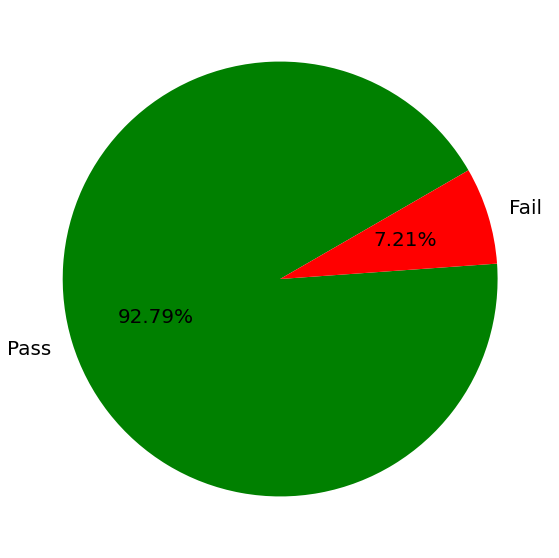

In [70]:
from matplotlib import style
import matplotlib as mpl
style.use('ggplot')

fig = plt.figure(1, figsize=(10,10))
labels = ['Pass','Fail']
colors = ['green','red']
ratio = [sum(stat_status_qc['rate'][0:3]),sum(stat_status_qc['rate'][3:7])]
patches, texts, autotexts=plt.pie(ratio, labels=labels, colors=colors, autopct='%.2f%%', shadow=False, startangle=30, textprops={'fontsize': 20})
texts[0].set_fontsize(20)
texts[1].set_fontsize(20)
plt.show()
#plt.savefig('./success_rate.png')

### Upload CSV Files to BigQuery

In [83]:
columnlist=["sample","pass","status","dup","fastq","fastq_rg","ubam","ubam_rg","vcf","cram","crai","job_fq2u","job_gatk"]
sample_qc_df_simple=sample_qc_df[columnlist]
sample_qc_df_simple.loc[sample_qc_df_simple['pass']=='fail',:].to_csv('gs://'+account['TRELLIS_BUCKET']+'/analysis-notebooks/gatk-failed-samples.csv')

# Create CSV with sample, [pass/fail] to update :Sample in Neo4j
sample_qc_status = sample_qc_df[(["sample","pass"])]
sample_qc_status.to_csv('gs://'+account['TRELLIS_BUCKET']+'/analysis-notebooks/sample-status.csv', header=False, index=False)

In [84]:
table_id = account['BIGQUERY_DATASET'] + '.sample_based_analysis'
projectid = account['GOOGLE_CLOUD_PROJECT']

pandas_gbq.to_gbq(
    sample_qc_df_simple, table_id, project_id=projectid, if_exists='append',
)

/usr/local/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
1it [00:06,  6.24s/it]
